In [1]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## micrograd Value

In [ ]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0 
        # var.grad = partial derivative of the output 
        # (i.e., end of the computational graph) wrt this variable
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out

    def __radd__(self, other): # other + self
        return self + other


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad  # d_out/d_self * out.grad  # out = self * other
            other.grad += self.data * out.grad  # d_out/d_other * out.grad
        out._backward = _backward
        return out


    def __rmul__(self, other): # other * self
        return self * other


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int or float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward
        return out


    def __truediv__(self, other): # self/other
        return self * other**-1

    def __neg__(self): # - self
        return self * -1

    def __sub__(self, other): # self-other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return -1*self + other


    def tanh(self):
        x = self.data
        # tanh(x) = [exp(2x)-1]/[exp(2x)+1]
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            # d/dx tanh(x) = 1-tanh(x)^2
            self.grad += (1.0-t**2) * out.grad
        out._backward = _backward
        return out


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out


    def backward(self):
        topo = []
        visited = set()
        
        def collect_leaves(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    collect_leaves(child)
                topo.append(node)

        collect_leaves(self)
        self.grad=1.0

        for node in reversed(topo):
            node._backward()


In [ ]:
import random

class Neuron:
    def __init__(self, nin):
        self.weight = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.weight, x)), self.bias)
        out = act.tanh()
        return out

    def parameters(self):
        return self.weight + [self.bias]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


# Training

## load the dataset

In [2]:
import torchvision
from torchvision import datasets, transforms


def load_MNIST(data_dir, split, batch_size, shuffle, kwargs={}):
    """ Load and preprocess MNIST data, return data loader. """

    train_flag= True if split=='train' else False
    transform= transforms.Compose(
        [transforms.ToTensor(), 
         transforms.Normalize((0.1307,), (0.3081,))
         ])
    dataset= datasets.MNIST(data_dir, train=train_flag, 
                            download=True, transform=transform)
    
    if batch_size ==0:  batch_size = len(dataset) # load full test set
    data_loader= torch.utils.data.DataLoader(dataset, 
                                             batch_size = batch_size, 
                                             shuffle = shuffle, 
                                             **kwargs)
    return data_loader


data_dir = './data'
input_size= 28**2
num_classes = 10

mbs = 128

train_loader = load_MNIST(data_dir, 'train', mbs, shuffle=True)
test_loader  = load_MNIST(data_dir, 'test', 0, shuffle=False)


In [ ]:
# how to get a single minibatch from the data loader
_inputs, _labels = next(iter(train_loader))

## plot some examples from the training set

In [ ]:
g = torch.Generator().manual_seed(4)

ind = torch.randperm(len(_labels), generator=g)[:10]
xs, ys = _inputs[ind], _labels[ind]


fig, axs = plt.subplots(2,5, figsize=(10,4))

for i, ax in enumerate(axs.flatten()):

    x = xs[i][0]
    y = ys[i]
    ax.imshow(x)

    ax.set_title(y.item())
    
    ax.set_xticks([])
    ax.set_yticks([])




## plot samples from one class

In [ ]:
# this loads the entire test set (10k), because it is not mini-batched
_inputs, _labels = next(iter(test_loader)) 

In [ ]:
g = torch.Generator().manual_seed(4)

target_class = 3
target_inds = torch.where(_labels== target_class)[0]
selection = torch.randperm(len(target_inds), generator=g)[:10]
xs, ys = _inputs[target_inds[selection]], _labels[target_inds[selection]]


fig, axs = plt.subplots(2,5, figsize=(10,4))

for i, ax in enumerate(axs.flatten()):

    x = xs[i][0]
    y = ys[i]
    ax.imshow(x)

    ax.set_title(y.item())
    
    ax.set_xticks([])
    ax.set_yticks([])



## define model

In [30]:
class miniNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(28*28, 32, bias=False)
        self.layer2 = nn.Linear(32, 10, bias=False)
        self.actfun = nn.ReLU()

        self.layers = [self.layer1, self.layer2]

        # for pruning
        self.layer1.mask = None
        self.layer2.mask = None
        
    @torch.no_grad()
    def apply_mask(self):
        for layer in self.layers:
            layer.weight *= layer.mask
        
    def forward(self, x):
        x = self.flatten(x) # flattens along all dimensions except the 0-th (the batch dim)
        out = self.layer1(x)
        out = self.actfun(out)
        out = self.layer2(out)

        return out
    

In [4]:
model = miniNet()

In [5]:
for p in model.named_parameters():
    print(f'{p[0]:15s} {p[1].shape}')

# for p in model.parameters():
#     print(p.shape)

layer1.weight   torch.Size([32, 784])
layer2.weight   torch.Size([10, 32])


## train model

In [ ]:
lr = 0.5

optimizer = torch.optim.SGD(model.parameters(), lr = lr) 
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,35], gamma=0.1)
lossfun = nn.CrossEntropyLoss()

In [ ]:
max_epochs = 40 # number of training epochs

step_counter = 0 # counting training iterations (gradient updates done)
epoch = 0

model.train()
while epoch <= max_epochs:
    loss_sum, total, correct = 0, 0, 0

    for mbi, mini_batch in enumerate(train_loader):
        step_counter += 1
        images, labels = mini_batch
        
        #=== forward pass
        outputs = model(images)
        loss = lossfun(outputs, labels)
        loss_sum += len(labels) * loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).cpu().sum().item()
        total += len(labels)

        #=== backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #==== epoch completed.

    train_loss = loss_sum/total
    train_acc = correct/total
    
    print(f'=== epoch {epoch:3}:  Loss {train_loss:.2f}  Acc {train_acc:.4f}')

    scheduler.step()
    epoch += 1 


## evaluate trained model

In [ ]:
model.eval()
loss_sum, total, correct = 0, 0, 0

for images, labels in test_loader:
    
    outputs = model(images)
    loss = lossfun(outputs, labels)
    loss_sum += len(labels) * loss.item()
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).cpu().sum().item()
    total += len(labels)

test_loss = loss_sum/total
test_acc = correct/total

print(f'Final Test Result:    Loss {test_loss:.2f}  Acc {test_acc:.4f}')

## save model checkpoint

In [ ]:
import os

def save_checkpoint(state, savepath):
    """Save model checkpoint."""
    # create (sub)dirs if not yet existent
    savedir = os.path.dirname(savepath)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    torch.save(state, f'{savepath}.ckpt')



state= {'epoch': epoch, 
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(), 
        'scheduler': scheduler.state_dict(),
        'test_loss': test_loss, 
        'test_acc': test_acc
        }

save_name= './checkpoints/final'
save_checkpoint(state, save_name)


## load model from checkpoint

In [31]:
# load model from checkpoint

model = miniNet()

lr = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr = lr) 
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,35], gamma=0.1)
lossfun = nn.CrossEntropyLoss()

save_name= './checkpoints/final'
checkpoint = torch.load(save_name+'.ckpt')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])

epoch = checkpoint['epoch']
loss = checkpoint['test_loss']
acc = checkpoint['test_acc']

model.eval()

miniNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=32, bias=False)
  (layer2): Linear(in_features=32, out_features=10, bias=False)
  (actfun): ReLU()
)

# Pruning

In [ ]:
"""
we shall focus on magnitude-based weight pruning post training, a simple and effective pruning technique. 
the model is first trained, then a set number of weights with the smallest magnitude are pruned. after that, 
an additional couple steps of training are done to fine-tune (adjust) the remaining non-pruned weights. 
doing a single pruning step is called 1-shot. this can be turned into an iterative process, where 
pruning followed by fine-tuning is repeated multiple times until the desired sparsity is reached. 
the iterative process is more expensive, but also yields better results.


before implementing magnitude-based pruning, lets analyse the trained model's weights in a couple of plots.
"""

## plotting the weights

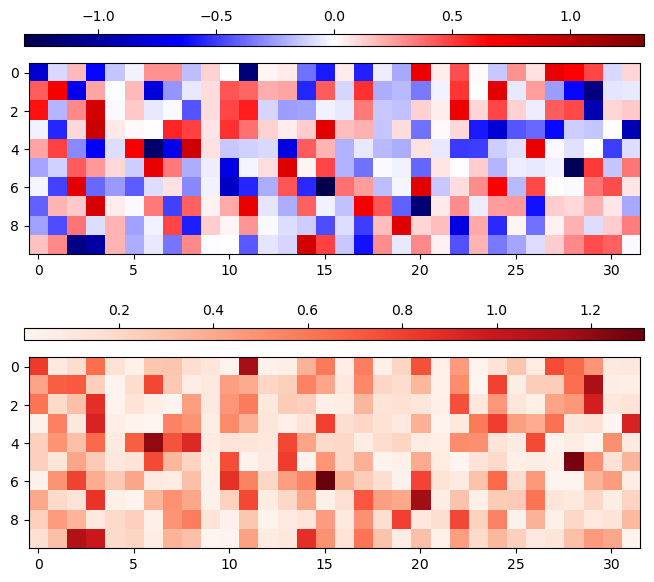

In [32]:
W = model.layer2.weight.data.detach()

fig, axs = plt.subplots(2,1, figsize=(8,7))

ax = axs[0]
im = ax.imshow(W, cmap='seismic', vmin = - abs(W).max(), vmax = abs(W).max())
plt.colorbar(im, orientation='horizontal', location='top', pad=0.07, aspect=50)


ax = axs[1]
im = ax.imshow(abs(W), cmap='Reds', vmin = abs(W).min(), vmax = abs(W).max())
plt.colorbar(im, orientation='horizontal', location='top', pad=0.07, aspect=50)

plt.show()



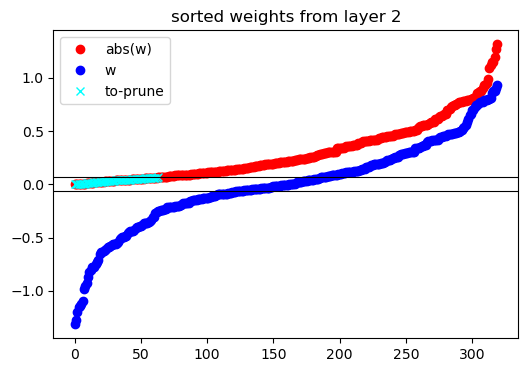

In [33]:
absw = sorted(abs(W.flatten()))
w = sorted(W.flatten())

p = int(0.2 * W.numel())
# get the indices and values of the p smallest elements from abs(W)
vals, inds = torch.topk(abs(W).flatten(), p, largest=False)
mi = W.flatten()[inds].min()
ma = W.flatten()[inds].max()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(absw, 'ro', label='abs(w)')
ax.plot(w, 'bo', label='w')

# add weights-to-prune
ax.plot(sorted(abs(W).flatten()[inds]), 'x', color='cyan', label='to-prune')
ax.axhline(mi, c='k', linewidth=0.8)
ax.axhline(ma, c='k', linewidth=0.8)

ax.legend()
ax.set_title('sorted weights from layer 2')
plt.show()

# magnitude-based pruning post training

In [22]:
"""
"pruning a weight" means setting its value to zero and keeping it fixed 
- that is, it will not be updated in further training steps.


however, setting a weight to zero is a non-differentiable operation,
and autograd can not handle it. (????)


therefore, we shall use masks: a mask is a binary-valued tensor of the same 
shape as the associated weight tensor, with "1" for weights that are to be kept 
and "0" for weights that are to be pruned. 
the mask is applied to the weight tensor via element-wise multiplication. 
(on the forward pass to the weight tensor, on the backward pass to the weight.grad tensor)
"""

'\n"pruning a weight" means setting its value to zero and keeping it fixed \n- that is, it will not be updated in further training steps.\n\n\nhowever, setting a weight to zero is a non-differentiable operation,\nand autograd can not handle it. (????)\n\n\ntherefore, we shall use masks: a mask is a binary-valued tensor of the same \nshape as the associated weight tensor, with "1" for weights that are to be kept \nand "0" for weights that are to be pruned. \nthe mask is applied to the weight tensor via element-wise multiplication. \n(on the forward pass to the weight tensor, on the backward pass to the weight.grad tensor)\n'

## make layer masks

In [34]:
model.layers

[Linear(in_features=784, out_features=32, bias=False),
 Linear(in_features=32, out_features=10, bias=False)]

In [35]:
prune_fract = 0.2  # fraction of weights to prune per layer


for layer in model.layers:

    layer.mask = torch.ones(layer.weight.shape, dtype = torch.bool) # all True (1) = all weights kept

    # the number of weights to prune
    k = int(prune_fract * layer.weight.numel()) 

    # get indices and values of the k smallest elements from abs(W)
    vals, inds = torch.topk(abs(layer.weight).flatten(), k, largest=False)
    
    # setting mask to False (0) for weights to be removed
    layer.mask.view(-1)[inds] = False


In [36]:
# check fraction of ones in masks (= weights to keep)
for layer in model.layers:
    s = torch.sum(layer.mask)/layer.weight.numel()
    print(s)

tensor(0.8000)
tensor(0.8000)


## prune model

In [62]:
for l,layer in enumerate(model.layers):
    print(torch.sum(layer.weight != 0))

tensor(20071)
tensor(256)


In [38]:
model.apply_mask()

In [60]:
for l,layer in enumerate(model.layers):
    print(f'=== layer {l+1} ===')
    numw_tot = layer.weight.numel()
    numw_nonz = torch.sum(layer.weight != 0).item()
    conn = (torch.sum(layer.weight != 0) / layer.weight.numel()).item()
    print(f'{numw_tot} - {numw_nonz} = {numw_tot-numw_nonz}')
    print(f'1-sparsity = {conn:.2f}')

=== layer 1 ===
25088 - 20071 = 5017
1-sparsity = 0.80
=== layer 2 ===
320 - 256 = 64
1-sparsity = 0.80


## eval pruned model

In [61]:
loss_sum, total, correct = 0, 0, 0

for images, labels in test_loader:
    
    outputs = model(images)
    loss = lossfun(outputs, labels)
    loss_sum += len(labels) * loss.item()
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).cpu().sum().item()
    total += len(labels)

test_loss = loss_sum/total
test_acc = correct/total

print(f'Test Result pre  pruning:  Loss {checkpoint["test_loss"]:.2f}  Acc {checkpoint["test_acc"]:.4f}')
print(f'Test Result post pruning:  Loss {test_loss:.2f}  Acc {test_acc:.4f}')

Test Result pre  pruning:  Loss 0.17  Acc 0.9594
Test Result post pruning:  Loss 0.17  Acc 0.9582
